# Mondo Transaction Data Analysis

"*Built for your smartphone, this is banking like never before. One that updates your balance instantly, gives intelligent notifications and is easy to use. We’re building what we think is the best bank on the planet and want you on board.*" - https://getmondo.co.uk/

We'll all be able to analysis our own financial data using Mondos API (https://getmondo.co.uk/docs/) and a bit of help from Python. The below will load in all the transactions from your account, slice and dice the data and output the analysis.

Please feel free to fill out the MONDO_ACCESS_TOKEN and MONDO_ACCOUNT_ID and have a look into your data. These can be found on https://developers.getmondo.co.uk/.

## Imports + Setup

These will be useful later on

In [1]:
%matplotlib inline
import collections

import requests
import numpy as np
import pandas as pd
from numpy import meshgrid
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from ipywidgets import widgets  

In [2]:
MONDO_URL = 'https://api.getmondo.co.uk'
MAP_URL = 'https://raw.githubusercontent.com/martinjc/UK-GeoJSON/master/json/electoral/eng/wpc_by_lad'

In [3]:
MONDO_ACCESS_TOKEN = widgets.Text(placeholder='MONDO_ACCESS_TOKEN')
MONDO_ACCESS_TOKEN

In [4]:
MONDO_ACCOUNT_ID = widgets.Text(placeholder='MONDO_ACCOUNT_ID')
MONDO_ACCOUNT_ID

## Functions

The below functions are useful for cleaning up data

In [5]:
def flatten(d, parent_key='', sep='_'):
    '''Flattens nested dictonaries'''
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

## Request

Its time to request the transactions information for your account.

In [6]:
headers = {'Authorization': 'Bearer ' + MONDO_ACCESS_TOKEN.value}
params = {
    'expand[]': 'merchant',
    'account_id': MONDO_ACCOUNT_ID.value
}

r = requests.get(MONDO_URL + '/transactions', params=params, headers=headers).json()

We only want to keep valid merchant addresses that have a longitude and latitude and are not approximated. If a merchant is approximated it will most lightly be either TFL or an online purchase.

In [7]:
df = pd.DataFrame([flatten(x) for x in r['transactions']])

valid_points = df[
    (df.merchant_address_longitude.notnull())
    & (df.merchant_address_latitude.notnull())
    & (df.merchant_address_approximate == False)
]

We'll load electoral data from London

In [8]:
points = []

for i in range(1, 34):
    x = requests.get('%s/E090000%s.json' % (MAP_URL, str(i).zfill(2))).json()
    for feature in x['features']:
        for a in feature['geometry']['coordinates']:
            if len(a) == 1:
                points.append(a[0])
            else:
                points.append(a)


## Plotting

Now we have all the information is onto plotting the map of London

In [9]:
m = Basemap(
    projection='mill', 
    llcrnrlon=valid_points.merchant_address_longitude.min() - .15, 
    llcrnrlat=valid_points.merchant_address_latitude.min() - .15,
    urcrnrlon=valid_points.merchant_address_longitude.max() + .15, 
    urcrnrlat=valid_points.merchant_address_latitude.max() + .15, 
    resolution='c'
)

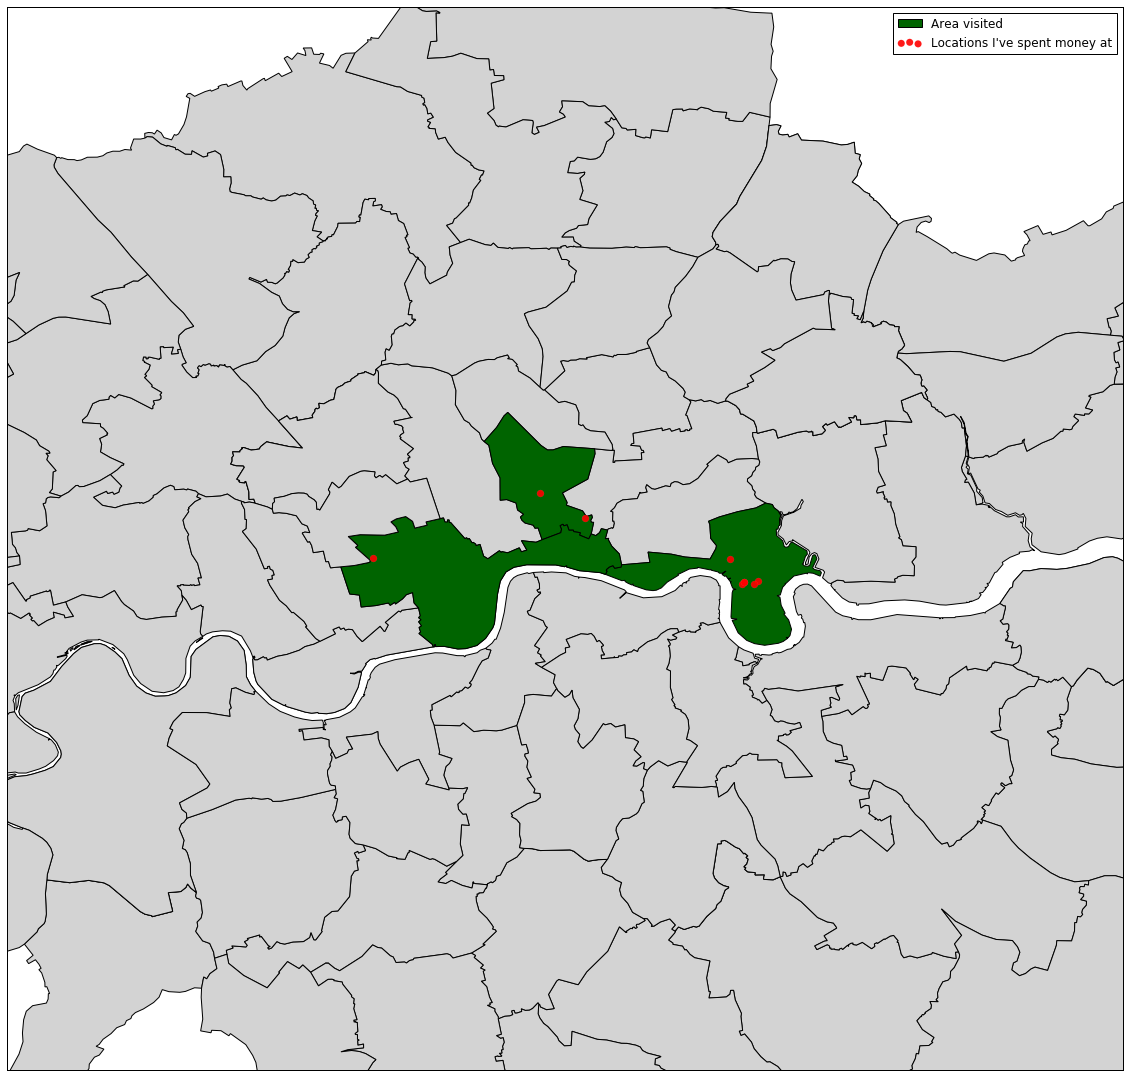

In [10]:
x, y = m(
    list(valid_points.merchant_address_longitude),
    list(valid_points.merchant_address_latitude)
)


fig = plt.figure(figsize=(20, 30))

seen = False
for point in points:
    xx = Polygon(list(map(lambda y: m(y[0], y[1]), point)), facecolor='lightgray')
    
    for xxx, yyy in zip(x, y):
        if xx.contains_point((xxx, yyy)):
            xx.set_facecolor('darkgreen')
            if not seen:
                xx.set_label('Area visited')
                seen = True
    plt.gca().add_patch(xx)
  
m.scatter(
    x,
    y,
    50, 
    marker='o', 
    lw=.05,
    facecolor='red', 
    edgecolor='w',
    alpha=0.9, 
    antialiased=True,
    label='Locations I\'ve spent money at', 
    zorder=3
)
plt.legend()
